In [1007]:
#Standard Packages:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
import time
import seaborn as sns
from scipy.optimize import minimize

#Statsmodels:
import statsmodels.api as sma
import statsmodels as sm
from statsmodels import tsa
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera
from scipy.stats import t, probplot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn.linear_model import LinearRegression
from pmdarima.arima.utils import ndiffs
from statsmodels.graphics.tsaplots import plot_acf
from pandas.tseries.frequencies import to_offset

from contextualized.easy import ContextualizedRegressor

In [1008]:
from scipy.optimize import minimize
import numpy as np
import pandas as pd

def difference(series, order=1):
    diffed = series.copy()
    for _ in range(order):
        diffed = diffed.diff().dropna()
    return diffed

def invert_difference(last_original, differenced):
    return last_original + differenced

def create_lag_features(series, p_lags, q_lags):
    X_ar = pd.DataFrame(index=series.index)
    for lag in p_lags:
        X_ar[f'lag_{lag}'] = series.shift(lag)
    
    X_ma = pd.DataFrame(index=series.index)
    for lag in q_lags:
        X_ma[f'ma_{lag}'] = 0
    
    if len(q_lags) > 0:
        X = pd.concat([X_ar, X_ma], axis=1)
    else:
        X = X_ar

    X = X.dropna()
    y = series.loc[X.index]
    return X, y
    


In [1009]:
from sklearn.linear_model import Ridge

def ARIMA(p, i, q, s, alpha=1.0):
    """
    Fit an ARIMA model with specified AR (p), differencing (i), and MA (q) lags.
    Uses Ridge Regression with specified regularization strength alpha.
    """
    if not isinstance(s, pd.Series):
        s = pd.Series(s)

    original_series = s.copy()
    differenced_series = difference(s, order=i)
    X, y = create_lag_features(differenced_series, p, q)

    if len(q) == 0:
        # No MA terms: fit immediately
        regression_model = Ridge(alpha=alpha)
        regression_model.fit(X, y)
        coef = regression_model.coef_
        intercept = regression_model.intercept_
        residuals = y - regression_model.predict(X)
    else:
        # First fit AR part only to get residuals
        ar_cols = [col for col in X.columns if col.startswith('lag_')]
        ar_X = X[ar_cols]

        ar_model = Ridge(alpha=alpha)
        ar_model.fit(ar_X, y)
        ar_coef = ar_model.coef_
        intercept = ar_model.intercept_

        residuals = y - ar_model.predict(ar_X)

        # Create true MA features from residuals
        for lag in q:
            X[f'ma_{lag}'] = residuals.shift(lag)

        combined = pd.concat([X, y], axis=1).dropna()
        X = combined[X.columns]
        y = combined[y.name]

        # Final fit with AR + MA features
        regression_model = Ridge(alpha=alpha)
        regression_model.fit(X, y)
        coef = regression_model.coef_
        intercept = regression_model.intercept_

        preds = regression_model.predict(X)
        print(preds.shape)
        residuals = y - preds

    sigma2 = np.var(residuals)
    n = len(residuals)
    log_likelihood = -0.5 * n * np.log(2 * np.pi * sigma2) - (0.5 / sigma2) * np.sum(residuals**2)

    max_p = max(p) if len(p) > 0 else 0
    max_q = max(q) if len(q) > 0 else 0
    max_lag = max(max_p, max_q)

    model_dict = {
        'p': p,
        'i': i,
        'q': q,
        'coef': coef,
        'intercept': intercept,
        'model': regression_model,
        'sigma2': sigma2,
        'log_likelihood': log_likelihood,
        'X_cols': X.columns,
        'original_series': original_series,
        'differenced_series': differenced_series,
        'residuals': residuals,
        'X_train': X,
        'y_train': y,
        'last_values': original_series.iloc[-max_lag:].values if max_lag > 0 else original_series.iloc[-1:].values,
        'last_diff_values': differenced_series.iloc[-max_lag:].values if max_lag > 0 and len(differenced_series) >= max_lag else differenced_series.values,
    }
    return model_dict


In [1010]:
def ContextualisedARIMA(p, i, q, s, C, alpha=0.1):
    """
    Fit an ARIMA model with specified AR (p), differencing (i), and MA (q) lags.
    Includes an intercept and uses standard Linear Regression directly.
    """
    if not isinstance(s, pd.Series):
        s = pd.Series(s)

    original_series = s.copy()
    differenced_series = difference(s, order=i)
    X, y = create_lag_features(differenced_series, p, q)

    if len(q) == 0:
        # No MA terms: fit immediately
        regression_model = ContextualizedRegressor(n_bootstraps=1, alpha=alpha)
        regression_model.fit(C, X, y,
            encoder_type="mlp",
            max_epochs=10,
          learning_rate=1e-2)
        coefs, intercepts = regression_model.predict_params(C)
        residuals = y - regression_model.predict(C, X)
    else:
        # First fit AR part only to get residuals
        ar_cols = [col for col in X.columns if col.startswith('lag_')]
        ar_X = X[ar_cols]

        ar_model = Ridge(alpha=1)
        ar_model.fit(ar_X, y)
        ar_coef = ar_model.coef_
        intercept = ar_model.intercept_

        residuals = y - ar_model.predict(ar_X)

        # Create true MA features from residuals
        for lag in q:
            X[f'ma_{lag}'] = residuals.shift(lag)

        combined = pd.concat([X, y], axis=1).dropna()
        X = combined[X.columns]
        y = combined[y.name]
        X_cols = X.columns

        C = C.loc[X.index].to_numpy()
        X_df = X
        X = X.to_numpy()
        y = y.to_numpy()

        # Final fit with AR + MA features
        regression_model = ContextualizedRegressor(n_bootstraps=1, alpha=alpha)
        regression_model.fit(C, X, y,
            encoder_type="mlp",
            max_epochs=10,
          learning_rate=1e-2)
        coefs, intercepts = regression_model.predict_params(C)
        preds = regression_model.predict(C, X).flatten()
        print(preds.shape)
        residuals = y - preds
        residuals = pd.Series(residuals, index=X_df.index)

    sigma2 = np.var(residuals)
    n = len(residuals)
    log_likelihood = -0.5 * n * np.log(2 * np.pi * sigma2) - (0.5 / sigma2) * np.sum(residuals**2)

    max_p = max(p) if len(p) > 0 else 0
    max_q = max(q) if len(q) > 0 else 0
    max_lag = max(max_p, max_q)

    model_dict = {
        'p': p,
        'i': i,
        'q': q,
        'coefs': coefs,
        'intercepts': intercepts,
        'model': regression_model,
        'sigma2': sigma2,
        'log_likelihood': log_likelihood,
        'X_cols': X_cols,
        'original_series': original_series,
        'differenced_series': differenced_series,
        'residuals': residuals,
        'X_train': X_df,
        'y_train': y,
        'C_train': C,
        'last_values': original_series.iloc[-max_lag:].values if max_lag > 0 else original_series.iloc[-1:].values,
        'last_diff_values': differenced_series.iloc[-max_lag:].values if max_lag > 0 and len(differenced_series) >= max_lag else differenced_series.values,
    }
    return model_dict

In [1011]:
def forecast(model_dict, steps=1):
    """
    Forecast future values based on the fitted ARIMA model with selected lags.
    This function produces forecasts one-step ahead, iteratively.
    """
    p_lags = model_dict['p']  # p is a list of AR lags
    i = model_dict['i']
    q_lags = model_dict['q']  # q is a list of MA lags
    model = model_dict['model']
    X_cols = model_dict['X_cols']
    original_series = model_dict['original_series']
    residuals = model_dict['residuals']
    
    # Current "history" for differenced series
    differenced_series = model_dict['differenced_series']
    
    forecasts = []
    
    # We keep track of recent differenced values and residuals
    current_diff = differenced_series.copy()
    current_resid = residuals.copy()
    
    for _ in range(steps):
        # Build AR features
        ar_features = []
        for lag in p_lags:
            if len(current_diff) - lag >= 0:
                ar_features.append(current_diff.iloc[-lag])
            else:
                ar_features.append(np.nan)
        
        # Build MA features
        ma_features = []
        for lag in q_lags:
            if len(current_resid) - lag >= 0:
                ma_features.append(current_resid.iloc[-lag])
            else:
                # For future predictions, we assume residuals are 0 if not available
                ma_features.append(0.0)
        
        # Combine AR and MA features in the same order as training
        row_data = ar_features + ma_features
        X_pred = pd.DataFrame([row_data], columns=X_cols)
        
        # Predict the differenced value
        diff_forecast = model.predict(X_pred)[0]
        
        # Update the differenced series and residuals
        # Generate a new index for the forecast step
        if isinstance(current_diff.index[-1], (int, float)):
            new_index = current_diff.index[-1] + 1
        else:
            # If it's a time index, step by frequency
            new_index = current_diff.index[-1] + pd.Timedelta('1D')
        
        current_diff = pd.concat([current_diff, pd.Series([diff_forecast], index=[new_index])])
        current_resid = pd.concat([current_resid, pd.Series([0.0], index=[new_index])])
        
        # Invert differencing
        if i > 1:
            raise NotImplementedError("Multiple differencing inversion not implemented.")
        
        last_original_value = original_series.iloc[-1] if len(forecasts) == 0 else forecasts[-1]
        inv_forecast = last_original_value + diff_forecast
        forecasts.append(inv_forecast)
    
    return forecasts


In [1012]:
def rolling_forecast(model_dict, true_series):
    """
    Perform a rolling forecast: predict one step ahead, then observe true value and update history.
    """
    from pandas.tseries.frequencies import to_offset

    p_lags = model_dict['p']
    i = model_dict['i']
    q_lags = model_dict['q']
    model = model_dict['model']
    X_cols = model_dict['X_cols']
    original_series = model_dict['original_series'].copy()
    differenced_series = model_dict['differenced_series'].copy()
    residuals = model_dict['residuals'].copy()
    print(residuals)

    start_idx = original_series.index[-1]
    true_series = true_series[true_series.index > start_idx]

    forecasts = []

    for t_idx in true_series.index:
        # Build AR features
        ar_features = []
        for lag in p_lags:
            if len(differenced_series) - lag >= 0:
                ar_features.append(differenced_series.iloc[-lag])
            else:
                ar_features.append(np.nan)

        # Build MA features
        ma_features = []
        for lag in q_lags:
            if len(residuals) - lag >= 0:
                ma_features.append(residuals.iloc[-lag])
            else:
                ma_features.append(0.0)

        row_data = ar_features + ma_features
        X_pred = pd.DataFrame([row_data], columns=X_cols)

        diff_forecast = model.predict(X_pred)[0]
        print(type(diff_forecast))

        if i > 1:
            raise NotImplementedError("Multiple differencing inversion not implemented.")

        last_original_value = original_series.iloc[-1]
        inv_forecast = last_original_value + diff_forecast
        forecasts.append(inv_forecast)

        # Update history:
        if t_idx in true_series.index:
            true_value = true_series.loc[t_idx]
        else:
            true_value = inv_forecast

        # Update series with the "observed" value
        original_series = pd.concat([original_series, pd.Series([true_value], index=[t_idx])])
        new_diff = true_value - last_original_value
        differenced_series = pd.concat([differenced_series, pd.Series([new_diff], index=[t_idx])])

        resid = true_value - inv_forecast
        residuals = pd.concat([residuals, pd.Series([resid], index=[t_idx])])

    return forecasts


In [1013]:
def c_rolling_forecast(model_dict, true_series, C):
    """
    Perform a rolling forecast: predict one step ahead, then observe true value and update history.
    """
    from pandas.tseries.frequencies import to_offset

    p_lags = model_dict['p']
    i = model_dict['i']
    q_lags = model_dict['q']
    model = model_dict['model']
    X_cols = model_dict['X_cols']
    original_series = model_dict['original_series'].copy()
    differenced_series = model_dict['differenced_series'].copy()
    residuals = model_dict['residuals'].copy()

    start_idx = original_series.index[-1]
    true_series = true_series[true_series.index > start_idx]

    forecasts = []

    for t_idx in true_series.index:
        # Build AR features
        ar_features = []
        for lag in p_lags:
            if len(differenced_series) - lag >= 0:
                ar_features.append(differenced_series.iloc[-lag])
            else:
                ar_features.append(np.nan)

        # Build MA features
        ma_features = []
        for lag in q_lags:
            if len(residuals) - lag >= 0:
                ma_features.append(residuals.iloc[-lag])
            else:
                ma_features.append(0.0)

        row_data = ar_features + ma_features
        X_pred = pd.DataFrame([row_data], columns=X_cols).to_numpy() 

        # get Contextual features
        C_pred = C.loc[[t_idx]].to_numpy() 
        #print(X_pred)
        #print(C_pred)

        diff_forecast = model.predict(C_pred,X_pred).item()

        if i > 1:
            raise NotImplementedError("Multiple differencing inversion not implemented.")

        last_original_value = original_series.iloc[-1]
        inv_forecast = last_original_value + diff_forecast
        forecasts.append(inv_forecast)

        # Update history:
        if t_idx in true_series.index:
            true_value = true_series.loc[t_idx]
        else:
            true_value = inv_forecast

        # Update series with the "observed" value
        original_series = pd.concat([original_series, pd.Series([true_value], index=[t_idx])])
        new_diff = true_value - last_original_value
        differenced_series = pd.concat([differenced_series, pd.Series([new_diff], index=[t_idx])])

        resid = true_value - inv_forecast
        residuals = pd.concat([residuals, pd.Series([resid], index=[t_idx])])

    return forecasts


In [1014]:
def get_significant_acf_lags(series, max_lag=40, alpha=0.05):
    # Drop missing values
    data = series.dropna()
    
    # Calculate ACF and confidence intervals
    acf_vals, confint = acf(data, nlags=max_lag, alpha=alpha)
    
    # Identify significant lags
    significant_lags = []
    for lag in range(1, len(acf_vals)):  # start from lag=1 since lag=0 is always 1
        lower, upper = confint[lag]
        # If CI does not include zero
        if lower > 0 or upper < 0:
            significant_lags.append(lag)
            
    return significant_lags

def get_significant_pacf_lags(series, max_lag=40, alpha=0.05):
    # Drop missing values
    data = series.dropna()
    
    # Calculate ACF and confidence intervals
    pacf_vals, confint = pacf(data, nlags=max_lag, alpha=alpha)
    
    # Identify significant lags
    significant_lags = []
    for lag in range(1, len(pacf_vals)):  # start from lag=1 since lag=0 is always 1
        lower, upper = confint[lag]
        # If CI does not include zero
        if lower > 0 or upper < 0:
            significant_lags.append(lag)
            
    return significant_lags

In [1015]:
# read daily close price data
file_path1 = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/data/ExxonMobil_CRSP_daily_data_alltime.csv'
file_path2 = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/data/ExxonMobil_Compustat_quarterly_ratiodata_alltime.csv' # Fundamental ratios (Compustat)

df1 = pd.read_csv(file_path1)
df2 = pd.read_csv(file_path2)

# Ensure that the date column is in datetime format
df1['date'] = pd.to_datetime(df1['date'], errors='coerce')
df2['qdate'] = pd.to_datetime(df2['qdate'])  # Financial ratios data
# Sort by qdate and public_date to ensure the most recent public_date comes last
df2_sorted = df2.sort_values(by=['qdate', 'public_date'])
# Drop duplicates to keep only the latest public_date for each qdate
df2_latest = df2_sorted.drop_duplicates(subset='qdate', keep='last')
# Make a copy to avoid modifying the original df3_latest
df2_latest_pct = df2_latest.copy()
# Select columns to calculate percentage change, excluding identifier and date columns
columns_to_change = ['npm', 'de_ratio', 'curr_ratio', 'ptb'] # Apply pct_change to each selected column and multiply by 100 to express as percentage
df2_latest_pct[columns_to_change] = df2_latest[columns_to_change].pct_change()

df = pd.merge_asof(
    df1,  # Daily data sorted by date
    df2_latest_pct,  # Fundamental data sorted by quarterly date
    left_on='date', right_on='qdate',  # Merge on dates
    direction='backward'  # Merge to the closest past quarter
)

# Set the 'date' column as the index
df.set_index('date', inplace=True)

# Convert df to a Pandas Series using the 'PRC' column
f = 'W-SUN' # 'W-SUN' means week ending on Sunday
df = df.resample(f).last()
df = df.dropna()

start_date = '2002-1-30'
end_train_date = '2018-9-30'
end_date = '2025-12-24'

# Filter the data according to the date range
df = df[(df.index >= start_date) & (df.index <= end_date)]
df_train = df[(df.index >= start_date) & (df.index <= end_train_date)]
df_test = df[(df.index > df_train.index[-1]) & (df.index < end_date)]

df_test.tail()

,PERMNO,TICKER_x,BIDLO,ASKHI,PRC,VOL,RET,OPENPRC,permno,adate,qdate,public_date,npm,de_ratio,curr_ratio,ptb,TICKER_y
date,,,,,,,,,,,,,,,,,
2023-12-03,11850.0,XOM,102.22,104.2200,102.99,17845276.0,0.002433,102.50,11850.0,2022-12-31,2023-09-30,2023-12-31,-0.161972,-0.035253,0.015482,-0.049867,XOM
2023-12-10,11850.0,XOM,98.75,99.7867,99.55,22074945.0,0.011481,99.02,11850.0,2022-12-31,2023-09-30,2023-12-31,-0.161972,-0.035253,0.015482,-0.049867,XOM
2023-12-17,11850.0,XOM,100.31,101.0000,100.90,55527018.0,-0.006694,100.59,11850.0,2022-12-31,2023-09-30,2023-12-31,-0.161972,-0.035253,0.015482,-0.049867,XOM
2023-12-24,11850.0,XOM,101.82,102.9400,101.91,12927831.0,0.001769,102.31,11850.0,2022-12-31,2023-09-30,2023-12-31,-0.161972,-0.035253,0.015482,-0.049867,XOM
2023-12-31,11850.0,XOM,99.62,100.5900,99.98,17746408.0,-0.002096,100.37,11850.0,2022-12-31,2023-09-30,2023-12-31,-0.161972,-0.035253,0.015482,-0.049867,XOM


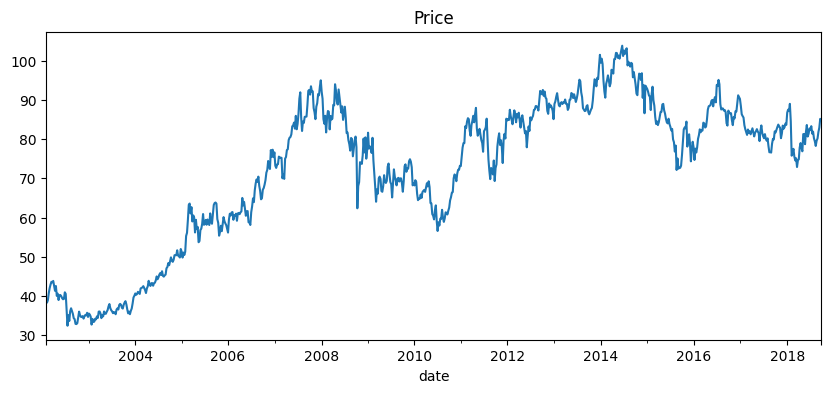

In [1016]:
s = df['PRC']
s_train = df_train['PRC']
s_test = df_test['PRC']

C_df = df[['npm', 'de_ratio', 'curr_ratio', 'ptb']]
C_train = df_train[['npm', 'de_ratio', 'curr_ratio', 'ptb']]
C_test = df_test[['npm', 'de_ratio', 'curr_ratio', 'ptb']]

# Plot the series
s_train.plot(title='Price', figsize=(10, 4))
plt.show()


In [1017]:
s_train.describe()
s_train.head()

date
2002-02-03    39.00
2002-02-10    38.29
2002-02-17    38.90
2002-02-24    40.72
2002-03-03    42.00
Freq: W-SUN, Name: PRC, dtype: float64

In [1018]:
C_test.head()

,npm,de_ratio,curr_ratio,ptb
date,,,,
2018-10-07,0.05,-0.015532,-0.00489,-0.094543
2018-10-14,0.05,-0.015532,-0.00489,-0.094543
2018-10-21,0.05,-0.015532,-0.00489,-0.094543
2018-10-28,0.05,-0.015532,-0.00489,-0.094543
2018-11-04,0.05,-0.015532,-0.00489,-0.094543


In [1019]:
# Perform Augmented Dickey-Fuller test
adf_result = adfuller(s_train)
# Print the result of the ADF test
#print("ADF Statistic:", adf_result[0])
#print("p-value:", adf_result[1])
#print("Used Lag:", adf_result[2])
#print("Number of Observations Used:", adf_result[3])
#print("Critical Values:", adf_result[4])
print("Conclusion: The series is stationary" if adf_result[1] < 0.05 else "Conclusion: The series is non-stationary")

Conclusion: The series is non-stationary


In [1020]:
# Find the number of differences (d) needed to make the series stationary
ndiffs_value = ndiffs(s)

# Print the result
print(f"Optimal number of differences (d): {ndiffs_value}")

Optimal number of differences (d): 1


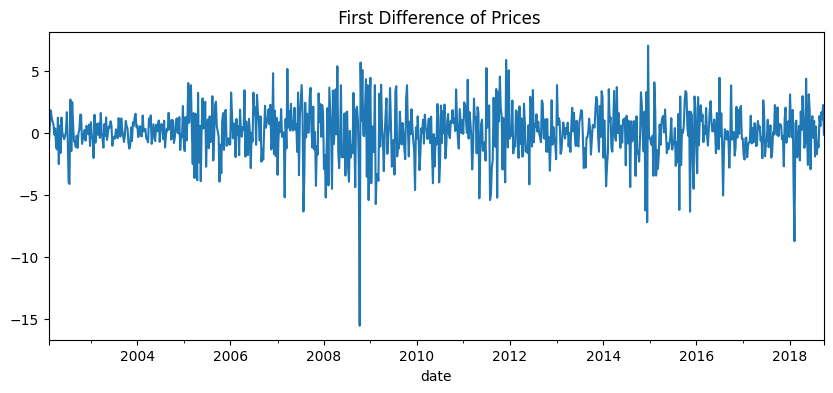

In [1021]:
s_train_diffed = difference(s_train)

s_train_diffed.plot(title=' First Difference of Prices', figsize=(10, 4))
plt.show()

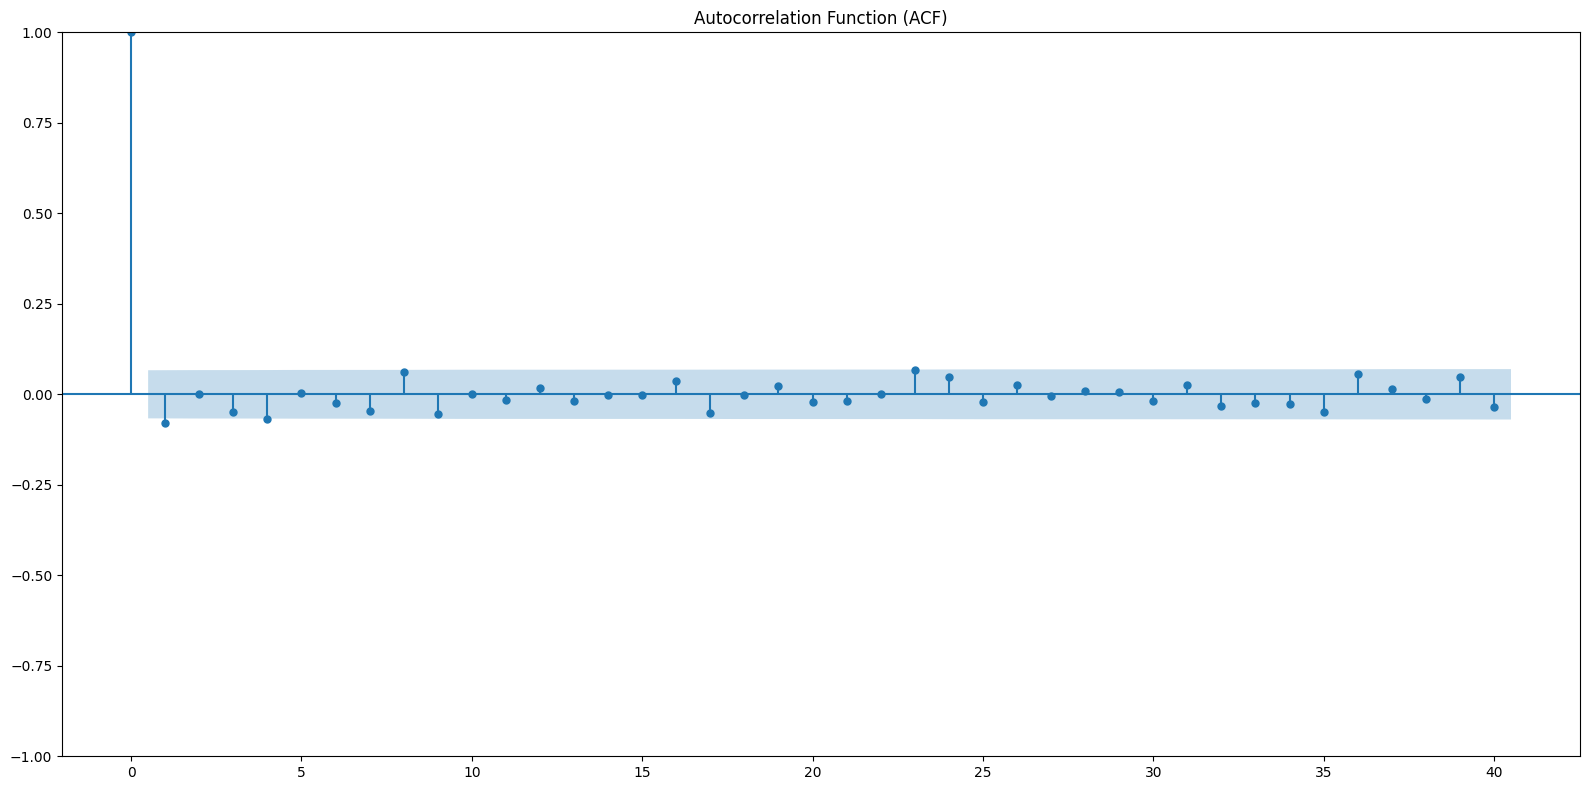

Significant ACF lags:
[1]


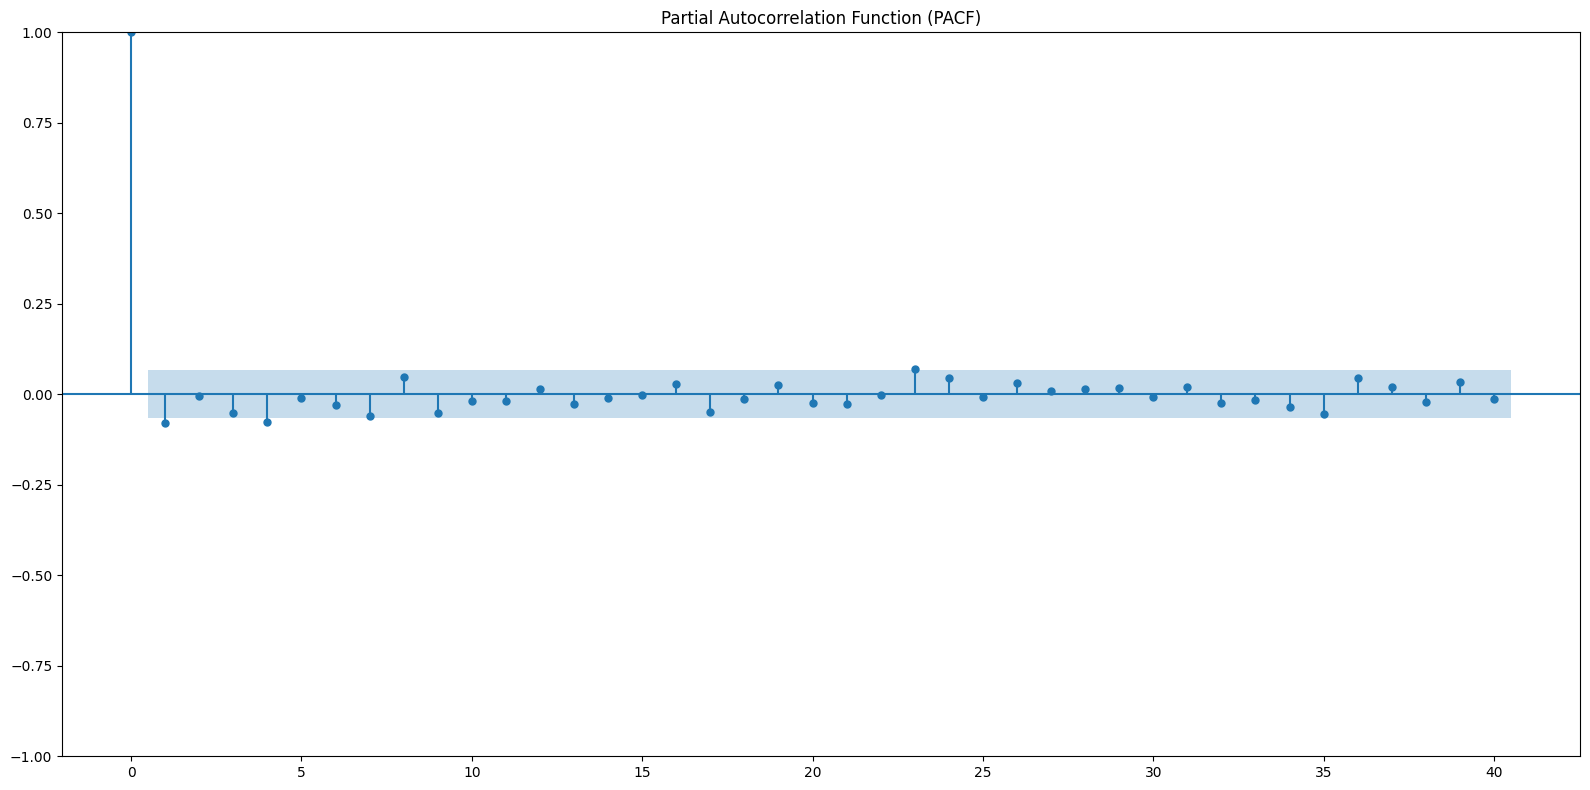

Significant PACF lags:
[1, 4, 23]


In [1022]:
# Create a figure with 2 subplots (one for the price and one for the ACF)
#fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig, ax = plt.subplots(figsize=(16, 8))
# Plot the ACF for the 'PRC' column (on the second subplot)
plot_acf(s_train_diffed.dropna(), lags=40, ax=ax)
ax.set_title('Autocorrelation Function (ACF)')
plt.tight_layout()
plt.show()
ax.set_title('Autocorrelation Function (ACF) of the First Difference')

# Print the significant lags
q = get_significant_acf_lags(s_train_diffed)
print("Significant ACF lags:")
print(q)

# Create a figure with 2 subplots (one for the price and one for the ACF)
#fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig, ax = plt.subplots(figsize=(16, 8))
# Plot the ACF for the 'PRC' column (on the second subplot)
plot_pacf(s_train_diffed.dropna(), lags=40, ax=ax)
ax.set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()
ax.set_title('Partial Autocorrelation Function (PACF) of the First Difference')

# Print the significant lags
p = get_significant_pacf_lags(s_train_diffed)

print("Significant PACF lags:")
print(p)

In [1023]:
print(C_train.shape)
C_train

(870, 4)


,npm,de_ratio,curr_ratio,ptb
date,,,,
2002-02-03,-0.047059,-0.116458,0.049601,0.026608
2002-02-10,-0.047059,-0.116458,0.049601,0.026608
2002-02-17,-0.047059,-0.116458,0.049601,0.026608
2002-02-24,-0.047059,-0.116458,0.049601,0.026608
2002-03-03,-0.047059,-0.116458,0.049601,0.026608
...,...,...,...,...
2018-09-02,-0.036145,-0.012972,-0.006075,-0.018680
2018-09-09,-0.036145,-0.012972,-0.006075,-0.018680
2018-09-16,-0.036145,-0.012972,-0.006075,-0.018680


In [1024]:
#p = [2, 3, 4, 5, 6, 7, 8, 9, 10, 16, 24, 30]

p = list(range(1,31))
p = list(range(1,8))
q = [1,2,3,4]

# Fit the ARIMA model
model_dict = ARIMA(p=p, i=1, q=q, s=s_train, alpha=100)  # ARIMA returns a model_dict

# Access and print the learned parameters
coef = model_dict['coef']  # Coefficients of the AR and MA terms
intercept = model_dict['intercept']  # Intercept of the linear model
X_cols = model_dict['X_cols']  # Column names of the features (lags)

# Display the parameters
print("Learned Parameters:")
print(f"Intercept: {intercept:.4f}")
print("Coefficients:")
for col, weight in zip(X_cols, coef):
    print(f"{col}: {weight:.4f}")


(858,)
Learned Parameters:
Intercept: 0.0592
Coefficients:
lag_1: -0.0903
lag_2: 0.0171
lag_3: 0.0053
lag_4: -0.0638
lag_5: -0.0095
lag_6: -0.0276
lag_7: -0.0520
ma_1: 0.0042
ma_2: -0.0318
ma_3: -0.0666
ma_4: -0.0088


<class 'pandas.core.series.Series'>


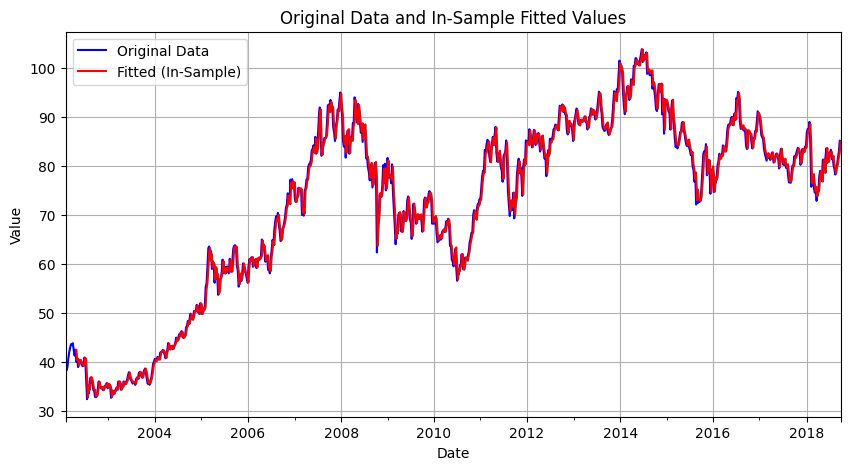

In [1025]:
model = model_dict['model']
X_cols = model_dict['X_cols']
original_series = model_dict['original_series']
differenced_series = model_dict['differenced_series']
i = model_dict['i']  # differencing order
X = model_dict['X_train']
y = model_dict['y_train']

p_lags = model_dict['p']
q_lags = model_dict['q']
residuals = model_dict['residuals']

# Predict on the differenced scale (in-sample predictions)
fitted_diff = model.predict(X)

print(type(residuals))

# Invert differencing (assuming i=1)
if i > 1:
    raise NotImplementedError("Multiple differencing inversion not implemented.")

fitted_diff_series = pd.Series(fitted_diff, index=X.index, name='FittedDiff')

# To invert differencing:
# original_series[t] = original_series[t-1] + differenced_prediction[t]

# Get the initial value before the first fitted point
first_date = fitted_diff_series.index[0]
one_step_before = original_series.index.get_loc(first_date) - 1
initial_value = original_series.iloc[one_step_before]

fitted_original_values = []
current_value = initial_value
for idx in fitted_diff_series.index:
    current_value = current_value + fitted_diff_series.loc[idx]
    fitted_original_values.append(current_value)
    current_value = original_series.loc[idx]

fitted_original_series = pd.Series(fitted_original_values, index=fitted_diff_series.index, name='Fitted')

# Plot the original data and fitted values
plt.figure(figsize=(10,5))
original_series.plot(label='Original Data', color='blue')
fitted_original_series.plot(label='Fitted (In-Sample)', color='red')

plt.title("Original Data and In-Sample Fitted Values")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

date
2002-04-28   -2.460595
2002-05-05    0.201027
2002-05-12   -1.707040
2002-05-19    0.946655
2002-05-26   -0.208689
                ...   
2018-09-02    0.403834
2018-09-09    1.416990
2018-09-16    1.130843
2018-09-23    2.299619
2018-09-30    0.066165
Freq: W-SUN, Name: PRC, Length: 858, dtype: float64
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.floa

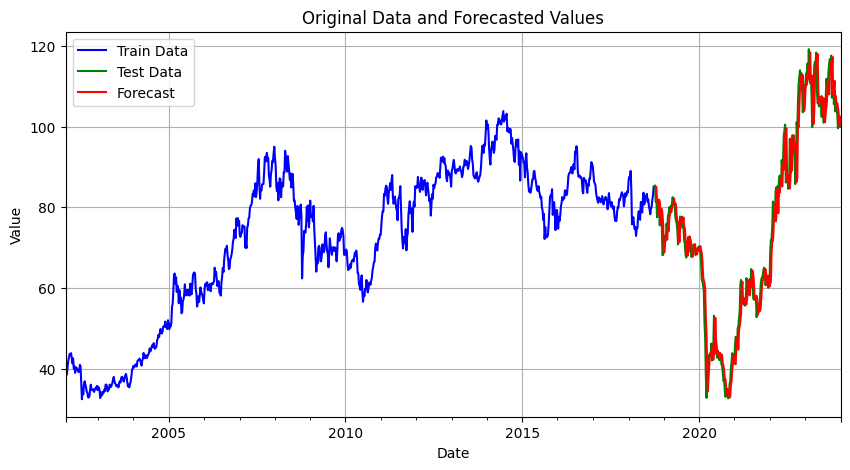

In [1026]:
preds = rolling_forecast(model_dict, s)

# Get the first timestamp
start = s_test.index[1]

# Create a datetime index for the forecast period
future_dates = pd.date_range(start, periods=len(preds), freq=f)

# Convert the predictions to a pandas Series
pred_series = pd.Series(preds, index=future_dates, name='Forecast')
mypred_series = pred_series
#print(pred_series)

# Plot the original data and the forecasted values
fig, ax = plt.subplots(figsize=(10, 5))
s_train.plot(ax=ax, label='Train Data', color='blue')
s_test.plot(ax=ax, label='Test Data', color='green')
pred_series.plot(ax=ax, label='Forecast', color='red')


plt.title("Original Data and Forecasted Values")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()



In [1027]:
# Create the DataFrame
preds = preds[:len(s_test)]  # truncate preds if too long
s_test = s_test.iloc[:len(preds)]  # truncate s_test if too long (if needed)

comparison = pd.DataFrame({
    'True': s_test.values,
    'Predicted': preds
}, index=s_test.index)

# Add 'Previous' column
comparison.insert(0, 'Previous', comparison['True'].shift(1))

# Fill the first 'Previous' with last value of training set
comparison.iloc[0, comparison.columns.get_loc('Previous')] = s_train.iloc[-1]

# Add 'True Difference' and 'Predicted Difference' columns
comparison['True Difference'] = comparison['True'] - comparison['Previous']
comparison['Predicted Difference'] = comparison['Predicted'] - comparison['Previous']

# Show it
comparison.tail(40)


,Previous,True,Predicted,True Difference,Predicted Difference
date,,,,,
2023-04-02,103.53,109.66,103.404907,6.13,-0.125093
2023-04-09,109.66,115.05,110.486117,5.39,0.826117
2023-04-16,115.05,116.05,114.977658,1.00,-0.072342
2023-04-23,116.05,116.01,115.431574,-0.04,-0.618426
2023-04-30,116.01,118.34,115.781618,2.33,-0.228382
2023-05-07,118.34,108.68,117.983049,-9.66,-0.356951
2023-05-14,108.68,105.78,109.006617,-2.90,0.326617
2023-05-21,105.78,106.26,105.580389,0.48,-0.199611
2023-05-28,106.26,104.97,106.421569,-1.29,0.161569


In [1028]:
directional_accuracy = 100 * (np.sign(comparison['True Difference']) == np.sign(comparison['Predicted Difference'])).mean()
print(f"Directional Accuracy: {directional_accuracy:.2f}%")

# MSE and MAE
mse = mean_squared_error(comparison['True'], comparison['Predicted'])
mae = mean_absolute_error(comparison['True'], comparison['Predicted'])

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


Directional Accuracy: 48.91%
Mean Squared Error (MSE): 11.3316
Mean Absolute Error (MAE): 2.4481


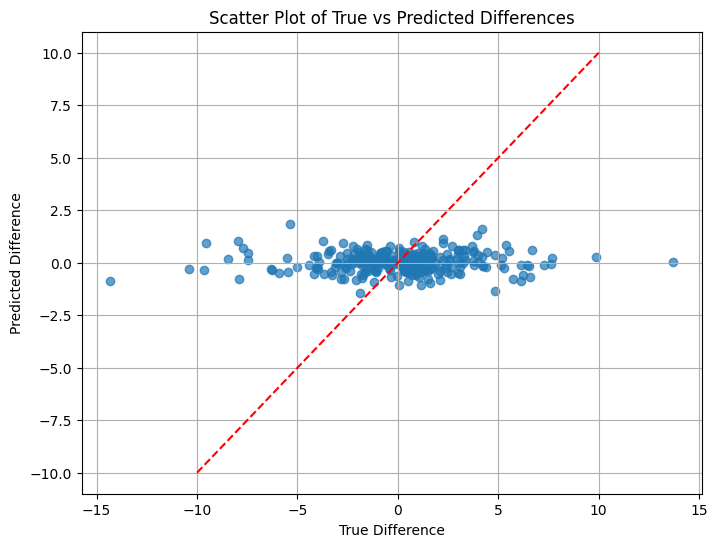

In [1029]:
plt.figure(figsize=(8, 6))
plt.scatter(comparison['True Difference'], comparison['Predicted Difference'], alpha=0.7)
plt.plot([-10, 10], [-10, 10], 'r--')  # 45-degree line for reference (perfect prediction)
plt.title('Scatter Plot of True vs Predicted Differences')
plt.xlabel('True Difference')
plt.ylabel('Predicted Difference')
plt.grid(True)
plt.show()

In [1030]:
# Fit the ARIMA model
p = list(range(1,31))
p = list(range(1,8))
q = [1,2,3]

c_model_dict = ContextualisedARIMA(p=p, i=1, q=q, s=s_train, C=C_train, alpha=5)  # ARIMA returns a model_dict

# Access and print the learned parameters
c_coefs = c_model_dict['coefs']  # Coefficients of the AR and MA terms
c_intercepts = c_model_dict['intercepts']  # Intercept of the linear model

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/edocampione/Desktop/Meng Engineering Science/4YP/models/lightning_logs/boot_0_checkpoints exists and is not empty.

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | metamodel | NaiveMetamodel | 1.7 K  | train
-----------------------------------------------------
1.7 K     Trainable params
0         Non-trainable params
1.7 K     Total params
0.007     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. 

(859,)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


In [1031]:
c_model = c_model_dict['model']
c_X_cols = c_model_dict['X_cols']
original_series = c_model_dict['original_series']
differenced_series = c_model_dict['differenced_series']
i = c_model_dict['i']  # differencing order
X = c_model_dict['X_train']
y = c_model_dict['y_train']
C = c_model_dict['C_train']

p_lags = c_model_dict['p']
q_lags = c_model_dict['q']
residuals = c_model_dict['residuals']

print(X.tail(1))

#residuals = pd.Series(residuals, index=X.index)
print(residuals)


            lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7      ma_1  \
date                                                                    
2018-09-30   2.25   1.09   1.66   0.55   1.36  -1.16  -0.78  2.305159   

                ma_2      ma_3  
date                            
2018-09-30  1.133766  1.407879  
date
2002-04-21    1.259720
2002-04-28   -2.478866
2002-05-05    0.539549
2002-05-12   -1.620631
2002-05-19    1.188889
                ...   
2018-09-02    0.612415
2018-09-09    1.539743
2018-09-16    1.118543
2018-09-23    2.204420
2018-09-30   -0.089528
Freq: W-SUN, Length: 859, dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


date
2002-04-21    1.259720
2002-04-28   -2.478866
2002-05-05    0.539549
2002-05-12   -1.620631
2002-05-19    1.188889
                ...   
2018-09-02    0.612415
2018-09-09    1.539743
2018-09-16    1.118543
2018-09-23    2.204420
2018-09-30   -0.089528
Freq: W-SUN, Length: 859, dtype: float64
(859,)


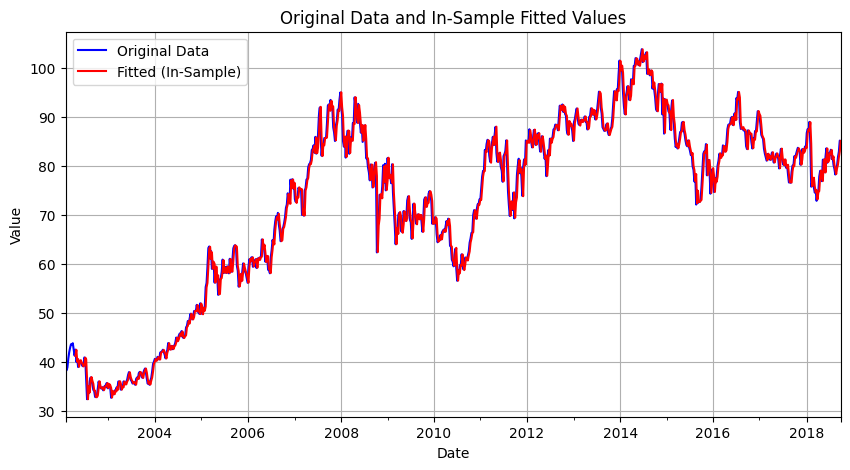

In [1032]:
print(residuals)

# Predict on the differenced scale (in-sample predictions)
fitted_diff = c_model.predict(C, X.to_numpy()).flatten()
print(fitted_diff.shape)

# Invert differencing (assuming i=1)
if i > 1:
    raise NotImplementedError("Multiple differencing inversion not implemented.")

fitted_diff_series = pd.Series(fitted_diff, index=X.index, name='FittedDiff')

# To invert differencing:
# original_series[t] = original_series[t-1] + differenced_prediction[t]

# Get the initial value before the first fitted point
first_date = fitted_diff_series.index[0]
one_step_before = original_series.index.get_loc(first_date) - 1
initial_value = original_series.iloc[one_step_before]

fitted_original_values = []
current_value = initial_value
for idx in fitted_diff_series.index:
    current_value = current_value + fitted_diff_series.loc[idx]
    fitted_original_values.append(current_value)
    current_value = original_series.loc[idx]

fitted_original_series = pd.Series(fitted_original_values, index=fitted_diff_series.index, name='Fitted')

# Plot the original data and fitted values
plt.figure(figsize=(10,5))
original_series.plot(label='Original Data', color='blue')
fitted_original_series.plot(label='Fitted (In-Sample)', color='red')

plt.title("Original Data and In-Sample Fitted Values")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [1033]:
c_preds = c_rolling_forecast(c_model_dict, s, C_df)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoa

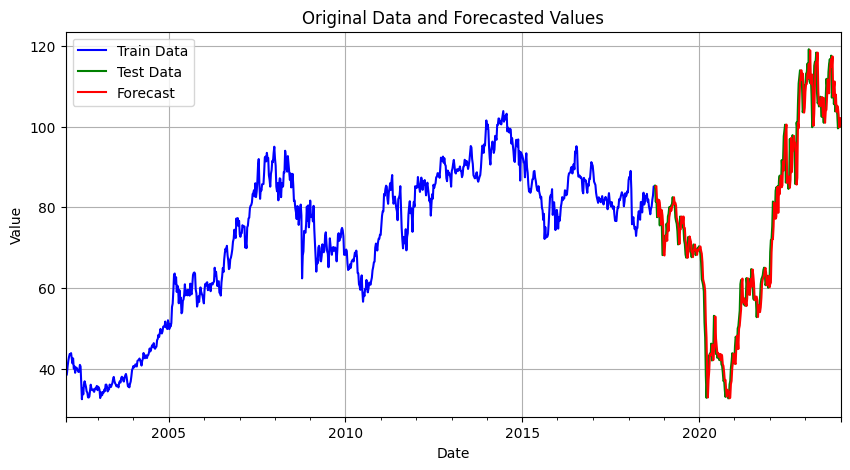

In [1034]:
# Get the first timestamp
start = s_test.index[1]

# Create a datetime index for the forecast period
future_dates = pd.date_range(start, periods=len(c_preds), freq=f)

# Convert the predictions to a pandas Series
pred_series = pd.Series(c_preds, index=future_dates, name='Forecast')
mypred_series = pred_series
#print(pred_series)

# Plot the original data and the forecasted values
fig, ax = plt.subplots(figsize=(10, 5))
s_train.plot(ax=ax, label='Train Data', color='blue')
s_test.plot(ax=ax, label='Test Data', color='green')
pred_series.plot(ax=ax, label='Forecast', color='red')


plt.title("Original Data and Forecasted Values")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [1035]:
# Create the DataFrame
preds = preds[:len(s_test)]  # truncate preds if too long
c_preds = c_preds[:len(s_test)]  # truncate preds if too long
s_test = s_test.iloc[:len(preds)]  # truncate s_test if too long (if needed)

comparison = pd.DataFrame({
    'True': s_test.values,
    'ARIMA': preds,
    'c ARIMA': c_preds
}, index=s_test.index)

# Add 'Previous' column
comparison.insert(0, 'Previous', comparison['True'].shift(1))

# Fill the first 'Previous' with last value of training set
comparison.iloc[0, comparison.columns.get_loc('Previous')] = s_train.iloc[-1]

# Add 'True Difference' and 'Predicted Difference' columns
comparison['True Difference'] = comparison['True'] - comparison['Previous']
comparison['ARIMA Predicted Difference'] = comparison['ARIMA'] - comparison['Previous']
comparison['c ARIMA Predicted Difference'] = comparison['c ARIMA'] - comparison['Previous']

# Show it
comparison.tail(40)


,Previous,True,ARIMA,c ARIMA,True Difference,ARIMA Predicted Difference,c ARIMA Predicted Difference
date,,,,,,,
2023-04-02,103.53,109.66,103.404907,103.162167,6.13,-0.125093,-0.367833
2023-04-09,109.66,115.05,110.486117,109.894057,5.39,0.826117,0.234057
2023-04-16,115.05,116.05,114.977658,115.250439,1.00,-0.072342,0.200439
2023-04-23,116.05,116.01,115.431574,116.078387,-0.04,-0.618426,0.028387
2023-04-30,116.01,118.34,115.781618,115.865615,2.33,-0.228382,-0.144385
2023-05-07,118.34,108.68,117.983049,118.334050,-9.66,-0.356951,-0.005950
2023-05-14,108.68,105.78,109.006617,108.696092,-2.90,0.326617,0.016092
2023-05-21,105.78,106.26,105.580389,105.538403,0.48,-0.199611,-0.241597
2023-05-28,106.26,104.97,106.421569,106.173878,-1.29,0.161569,-0.086122


In [1036]:
directional_accuracy = 100 * (np.sign(comparison['True Difference']) == np.sign(comparison['ARIMA Predicted Difference'])).mean()
c_directional_accuracy = 100 * (np.sign(comparison['True Difference']) == np.sign(comparison['c ARIMA Predicted Difference'])).mean()

# MSE and MAE
mse = mean_squared_error(comparison['True'], comparison['ARIMA'])
mae = mean_absolute_error(comparison['True'], comparison['ARIMA'])
c_mse = mean_squared_error(comparison['True'], comparison['c ARIMA'])
c_mae = mean_absolute_error(comparison['True'], comparison['c ARIMA'])

print("ARIMA:")
print(f"Directional Accuracy: {directional_accuracy:.2f}%")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print('')
print("Contextualised ARIMA:")
print(f"Directional Accuracy: {c_directional_accuracy:.2f}%")
print(f"Mean Squared Error (MSE): {c_mse:.4f}")
print(f"Mean Absolute Error (MAE): {c_mae:.4f}")

ARIMA:
Directional Accuracy: 48.91%
Mean Squared Error (MSE): 11.3316
Mean Absolute Error (MAE): 2.4481

Contextualised ARIMA:
Directional Accuracy: 52.55%
Mean Squared Error (MSE): 11.1900
Mean Absolute Error (MAE): 2.4285
